In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from functools import *
import time
import tensorflow as tf
from tensorflow.python.ops import rnn,rnn_cell
from sklearn.metrics import mean_squared_error

## Helper functions for data shaping

In [2]:
def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [3, 4, 5]
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])

    return np.array(rnn_df, dtype=np.float32)


def split_data(data, test_size=0.1):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))

    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]

    return df_train, df_test


def prepare_data(data, time_steps, labels=False, test_size=0.1):
    """
    Given the number of `time_steps` and some data,
    prepares training and test data for an lstm cell.
    """
    df_train, df_test = split_data(data, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))


def load_csvdata(rawdata, time_steps, seperate=False):
    data = rawdata
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    train_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    train_y, test_y = prepare_data(data['b'] if seperate else data, time_steps, labels=True)
    return dict(train=train_x, test=test_x), dict(train=train_y, test=test_y)



# Dataset 1: $x\cdot\sin(x)$
## Data and Parameters

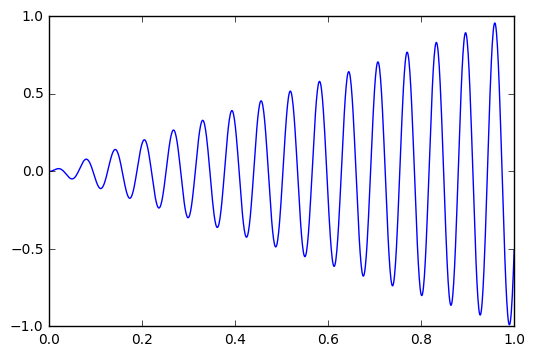

In [7]:
table = pd.read_csv("csv/project02_task2.csv")
tablex=table['x']
tabley=table['y']
plt.plot(tablex,tabley)

timesteps = 10
batch_size = 10
trainingsteps = 5000
rnn_size = 20
data, labels = load_csvdata(tabley, timesteps, seperate=False)
n_samples=data['train'].shape[0]

## The Network

In [8]:
x = tf.placeholder(tf.float32,[None, timesteps, 1])
y = tf.placeholder(tf.float32)
def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,1])),
             'biases':tf.Variable(tf.random_normal([1]))}
    
    x=tf.transpose(x,[1,0,2])
    
    x=tf.reshape(x,[-1,1])
    
    x=tf.split(0,timesteps,x)
    
    
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
        
    with tf.variable_scope('rnn1') as scope:
        scope.reuse_variables()
        outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    
    output=tf.matmul(outputs[-1],layer['weights'] + layer['biases'])
    
    return output

## Training and Testing

In [9]:
def train_and_test_rnn(x, y, trainingsteps, batch_sisze):
    pred = recurrent_neural_network(x)
    cost = tf.reduce_mean(tf.squared_difference(pred,y))
    opt = tf.train.AdamOptimizer().minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        j=0
        k=0
        while j<trainingsteps:
            epoch_loss = 0
            for i in range(int(n_samples/batch_size)):
                epoch_x = data['train'][i*batch_size:(i+1)*batch_size].tolist()
                epoch_y = labels['train'][i*batch_size:(i+1)*batch_size].tolist()
                _, c = sess.run([opt, cost], 
                                     feed_dict = {x:epoch_x, y:epoch_y})
                epoch_loss = epoch_loss + c
                j=j+1
                if j==trainingsteps:
                    k=k-1
                    break
            k=k+1
            print('Steps done: ' + str(j)+' / Testset completed ' + str(k) + ' times '+
                  '/ Loss: ' + str(epoch_loss/int(n_samples/batch_size)))
        print( 'Training finished!'  )
        prediction = sess.run([pred], feed_dict = {x:data['test'].tolist()})
    return prediction

In [10]:
start_time = time.time()
#train_and_test_rnn(data['train'].tolist(), labels['train'].tolist())
prediction = train_and_test_rnn(x,y,trainingsteps, batch_size)
print('Time:' + str(time.time()-start_time))

Steps done: 89 / Testset completed 1 times / Loss: 0.00578513718194
Steps done: 178 / Testset completed 2 times / Loss: 0.000417601460632
Steps done: 267 / Testset completed 3 times / Loss: 0.000227699070838
Steps done: 356 / Testset completed 4 times / Loss: 0.000629805095943
Steps done: 445 / Testset completed 5 times / Loss: 0.0010018030321
Steps done: 534 / Testset completed 6 times / Loss: 6.37031282208e-05
Steps done: 623 / Testset completed 7 times / Loss: 5.2762646691e-05
Steps done: 712 / Testset completed 8 times / Loss: 7.18950467546e-05
Steps done: 801 / Testset completed 9 times / Loss: 8.67072595222e-05
Steps done: 890 / Testset completed 10 times / Loss: 0.000122362862795
Steps done: 979 / Testset completed 11 times / Loss: 0.00110750327865
Steps done: 1068 / Testset completed 12 times / Loss: 0.000918141884515
Steps done: 1157 / Testset completed 13 times / Loss: 1.72436659061e-05
Steps done: 1246 / Testset completed 14 times / Loss: 1.51633563412e-05
Steps done: 1335 /

MSE on test set: 0.000050


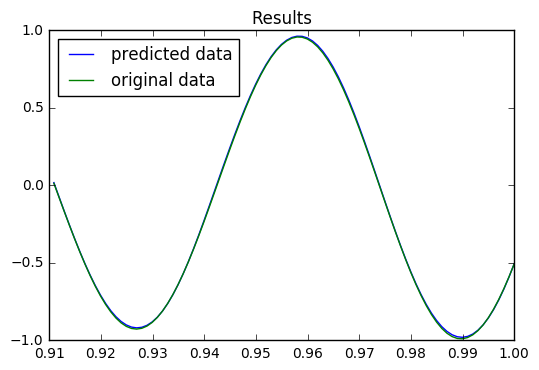

In [15]:
#x_axis of testset for plots
x_axis_predicted=tablex[1000-data['test'].shape[0]:1000]
#correct y values of testset
real_y_predicted=tabley[1000-data['test'].shape[0]:1000]
# plot for the test set

score = mean_squared_error(prediction[0], labels['test'])
print ("MSE on test set: %f" % score)

fig, ax = plt.subplots(1)

plot_predicted, = ax.plot(x_axis_predicted,prediction[0], label='predicted data')

plot, = ax.plot(x_axis_predicted,real_y_predicted, label='original data')

plt.title('Results')

plt.legend(handles=[plot_predicted, plot],loc=2)
plt.show()

# Dataset 2: Sunspots
## Data and Parameters

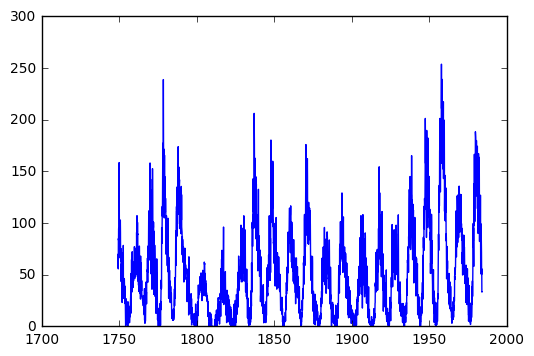

In [3]:
table = pd.read_csv("csv/sunspots.csv")
tablex=table['x']
tabley=table['y']
plt.plot(tablex,tabley)
timesteps = 100
batch_size = 100
trainingsteps = 5000
rnn_size = 150
data, labels = load_csvdata(tabley, timesteps, seperate=False)
n_samples=data['train'].shape[0]

## The Network

In [4]:
x = tf.placeholder(tf.float32,[None, timesteps, 1])
y = tf.placeholder(tf.float32)
def recurrent_neural_network2(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,1])),
             'biases':tf.Variable(tf.random_normal([1]))}
    
    x=tf.transpose(x,[1,0,2])
    
    x=tf.reshape(x,[-1,1])
    
    x=tf.split(0,timesteps,x)
    
    with tf.variable_scope('LSTMCell2', reuse=False):
        lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
        
    with tf.variable_scope('rnn2', reuse=None):
        outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    
    output=tf.matmul(outputs[-1],layer['weights'] + layer['biases'])
    
    return output

## Training and Testing

In [5]:
def train_and_test_rnn2(x, y, trainingsteps, batch_sisze):
    pred = recurrent_neural_network2(x)
    cost = tf.reduce_mean(tf.squared_difference(pred,y))
    opt = tf.train.AdamOptimizer().minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        j=0
        k=0
        while j<trainingsteps:
            epoch_loss = 0
            for i in range(int(n_samples/batch_size)):
                epoch_x = data['train'][i*batch_size:(i+1)*batch_size].tolist()
                epoch_y = labels['train'][i*batch_size:(i+1)*batch_size].tolist()
                _, c = sess.run([opt, cost], 
                                     feed_dict = {x:epoch_x, y:epoch_y})
                epoch_loss = epoch_loss + c
                j=j+1
                if j==trainingsteps:
                    k=k-1
                    break
            k=k+1
            print('Steps done: ' + str(j)+' / Testset completed ' + str(k) + ' times '+
                  '/ Loss: ' + str(epoch_loss/int(n_samples/batch_size)))
        print( 'Training finished!'  )
        prediction = sess.run([pred], feed_dict = {x:data['test'].tolist()})
    return prediction

In [6]:
start_time = time.time()
#train_and_test_rnn(data['train'].tolist(), labels['train'].tolist())
prediction = train_and_test_rnn2(x,y,trainingsteps, batch_size)
print('Time:' + str(time.time()-start_time))

Steps done: 24 / Testset completed 1 times / Loss: 3100.72464212
Steps done: 48 / Testset completed 2 times / Loss: 1695.52087355
Steps done: 72 / Testset completed 3 times / Loss: 1153.14537382
Steps done: 96 / Testset completed 4 times / Loss: 837.165768147
Steps done: 120 / Testset completed 5 times / Loss: 730.745586077
Steps done: 144 / Testset completed 6 times / Loss: 661.507001082
Steps done: 168 / Testset completed 7 times / Loss: 596.231470744
Steps done: 192 / Testset completed 8 times / Loss: 572.171175957
Steps done: 216 / Testset completed 9 times / Loss: 546.352269332
Steps done: 240 / Testset completed 10 times / Loss: 528.161870639
Steps done: 264 / Testset completed 11 times / Loss: 505.985702833
Steps done: 288 / Testset completed 12 times / Loss: 480.001175404
Steps done: 312 / Testset completed 13 times / Loss: 464.062972864
Steps done: 336 / Testset completed 14 times / Loss: 450.015605132
Steps done: 360 / Testset completed 15 times / Loss: 438.732385
Steps done:

MSE on test set: 378.862976


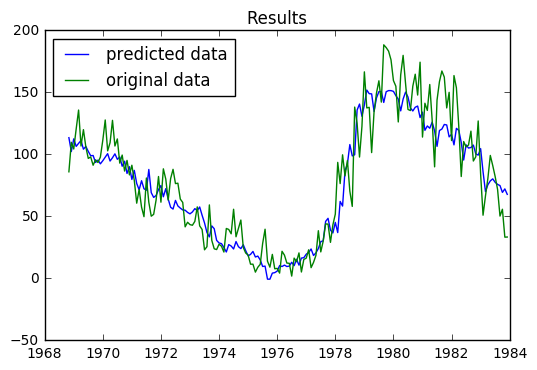

In [7]:
#x_axis of testset for plots
x_axis_predicted=tablex[2820-data['test'].shape[0]:2820]
#correct y values of testset
real_y_predicted=tabley[2820-data['test'].shape[0]:2820]
# plot for the test set
score = mean_squared_error(prediction[0], labels['test'])
print ("MSE on test set: %f" % score)

fig, ax = plt.subplots(1)

plot_predicted, = ax.plot(x_axis_predicted,prediction[0], label='predicted data')

plot, = ax.plot(x_axis_predicted,real_y_predicted, label='original data')

plt.title('Results')

plt.legend(handles=[plot_predicted, plot],loc=2)
plt.show()